In [110]:
import pyhdb
import yaml
import pandas as pd
import numpy as np

In [111]:
with open('../credentials.yml', 'r') as f:
    credentials = yaml.load(f)

In [112]:
connection = pyhdb.connect(**credentials)
cursor = connection.cursor()

In [113]:
# Distinct years contain 0
query = 'SELECT DISTINCT VISITYEAR FROM TUKGRP4."Transcript"'
cursor.execute(query)
cursor.fetchall()

[(0,), (2009,), (2010,), (2011,), (2012,)]

In [120]:
# Select doc visits by age group
query = \
'''
    SELECT agegroup, AVG(visits), MIN(visits), MAX(visits), MEDIAN(visits)
    FROM (
    SELECT *,
      CASE
      WHEN AGE < 10 THEN 1
      WHEN AGE < 20 THEN 2
      WHEN AGE < 30 THEN 3
      WHEN AGE < 40 THEN 4
      WHEN AGE < 50 THEN 5
      WHEN AGE < 60 THEN 6
      WHEN AGE < 70 THEN 7
      WHEN AGE < 80 THEN 8
      WHEN AGE < 90 THEN 9
      ELSE 10 END AS agegroup
    FROM (
      SELECT
        t.PATIENTGUID,
        2012 - p.YEAROFBIRTH as age,
        COUNT(t.VISITYEAR) as visits
      FROM TUKGRP4."Transcript" AS t
        JOIN TUKGRP4."Patient" AS p ON t.PATIENTGUID = p.PATIENTGUID
      WHERE t.VISITYEAR != 0
      GROUP BY t.PATIENTGUID, p.YEAROFBIRTH
    )
    ) GROUP BY agegroup;
'''
cursor.execute(query)
agg_data = cursor.fetchall()[::-1]

In [130]:
df = pd.DataFrame(agg_data)
df.columns = ['group', 'avg', 'min', 'max', 'median']
df

,group,avg,min,max,median
0,2,10.163461,2,92,7
1,3,11.148331,1,104,8
2,4,11.146517,1,218,7
3,5,11.945614,1,252,8
4,6,13.010355,1,260,9
5,7,13.399787,3,275,9
6,8,13.351435,1,130,10
7,9,15.833333,1,136,12
8,10,14.871794,3,41,11


In [131]:
def generate_range(size):
    start = 10
    for _ in range(size):
        yield '<{}'.format(start)
        start += 10

In [136]:
from scipy.interpolate import interp1d

def get_interpolate_func(data):
    return interp1d(range(len(data)), data.map(lambda x: float(x)))

In [137]:
from sklearn.metrics import r2_score

def plot_interpolated_points(series, label, plt, plot_type):
    entries = range(len(series))
    func = get_interpolate_func(series)
    plt.plot(series , plot_type, label=label)
    interpolated_points = [func(x) for x in entries]
    plt.plot(interpolated_points)
    return round(r2_score(series, interpolated_points), 2)

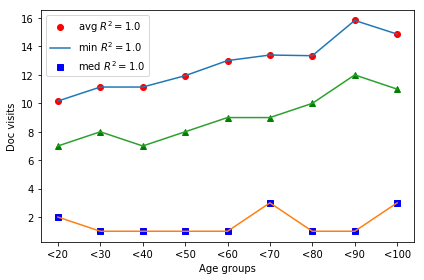

In [138]:
import matplotlib.pyplot as plt

avg_err = plot_interpolated_points(df['avg'], 'average', plt, 'ro')
min_err = plot_interpolated_points(df['min'], 'min', plt, 'bs')
median_err = plot_interpolated_points(df['median'], 'median', plt, 'g^')

x_labels = list(generate_range(10))[1:]
plt.xticks(range(len(x_labels)), x_labels)

plt.legend(['avg $R^2={}$'.format(avg_err),
            'min $R^2={}$'.format(min_err),
            'med $R^2={}$'.format(median_err)], loc='best')

plt.xlabel('Age groups')
plt.ylabel('Doc visits')

plt.tight_layout()
plt.show()